### Import libraries

In [1]:
# Import necessary libraries
import pandas as pd
import os
from tqdm import tqdm
from hazm import Normalizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
import random
import seaborn as sns

### ----------------------------------------
### Set Device (CPU or GPU)

In [2]:
# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### ----------------------------------------
### Load Local Persian Sentiment Model

In [3]:
# MODEL_NAME = "frameai/PersianSentiment"
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Path to the locally downloaded model
local_model_path = "../models/PersianSentiment/models--frameai--PersianSentiment/snapshots/349f79da484900b28f2c01d35f2806c1856949da"

# Load tokenizer and model from the local path
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
model = AutoModelForSequenceClassification.from_pretrained(local_model_path)

# Move model to the selected device (GPU or CPU)
model.to(device)
model.eval()  # Set model to evaluation mode

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-15): 16 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

### ----------------------------------------
### Define Text Preprocessing Function

In [4]:
# Initialize Persian text normalizer
normalizer = Normalizer()

def preprocess(text):
    """
    Normalize and clean Persian text.
    """
    text = normalizer.normalize(str(text))
    text = " ".join(text.split())  # Remove extra whitespaces
    return text

### ----------------------------------------
### Define Batch Sentiment Prediction Function

In [5]:
def predict_sentiments_batch(texts, batch_size=32):
    """
    Predict sentiments in batches to speed up processing.
    Correct label order: 0=negative, 1=neutral, 2=positive
    """
    results = []
    labels = ["negative", "neutral", "positive"]
    for i in tqdm(range(0, len(texts), batch_size), desc="Batch processing"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {k:v.to(device) for k,v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        labels_idx = torch.argmax(outputs.logits, dim=-1).cpu().tolist()
        results.extend([labels[idx] for idx in labels_idx])
    return results

### ----------------------------------------
### Setup Data Paths and Output Folder

In [6]:
# Define paths to input data and output folder
data_path = "../data"
output_path = "../data/sentiment_results_batch"
os.makedirs(output_path, exist_ok=True)

# List all CSV files in the input data folder
csv_files = [f for f in os.listdir(data_path) if f.endswith(".csv")]

### Process CSV Files and Predict Sentiments

In [7]:
# Loop through all CSV files, preprocess, predict sentiments, and save results
for file in csv_files:
    print(f"\nProcessing {file}...")
    df = pd.read_csv(os.path.join(data_path, file))
    df['text'] = df['text'].apply(preprocess)
    
    sentiments = predict_sentiments_batch(df['text'].tolist(), batch_size=32)
    df['sentiment'] = sentiments
    
    output_file = os.path.join(output_path, file)
    df.to_csv(output_file, index=False, encoding="utf-8-sig")
    print(f"✅ Saved batch sentiment results to {output_file}")


Processing bbcpersian_messages.csv...


Batch processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [02:53<00:00,  1.80it/s]


✅ Saved batch sentiment results to ../data/sentiment_results_batch/bbcpersian_messages.csv

Processing iranintlTV_messages.csv...


Batch processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:54<00:00,  1.77it/s]


✅ Saved batch sentiment results to ../data/sentiment_results_batch/iranintlTV_messages.csv

Processing kafiha_messages.csv...


Batch processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:51<00:00,  1.80it/s]


✅ Saved batch sentiment results to ../data/sentiment_results_batch/kafiha_messages.csv

Processing radiofarda_messages.csv...


Batch processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [02:57<00:00,  1.75it/s]


✅ Saved batch sentiment results to ../data/sentiment_results_batch/radiofarda_messages.csv

Processing TweetyChannel_messages.csv...


Batch processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [02:50<00:00,  1.80it/s]

✅ Saved batch sentiment results to ../data/sentiment_results_batch/TweetyChannel_messages.csv


### ----------------------------------------
### Plot Sentiment Distribution for Each CSV File

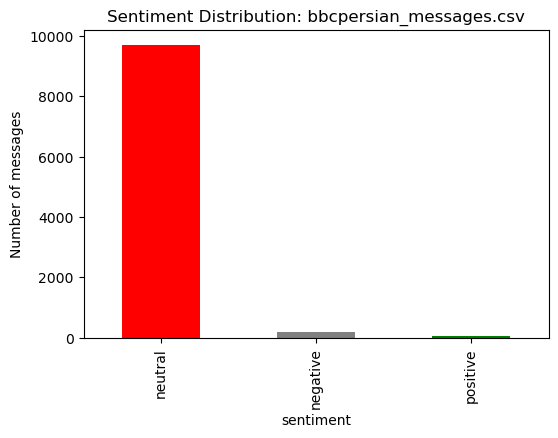

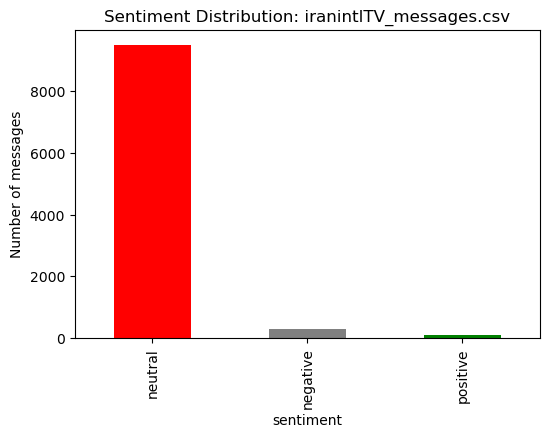

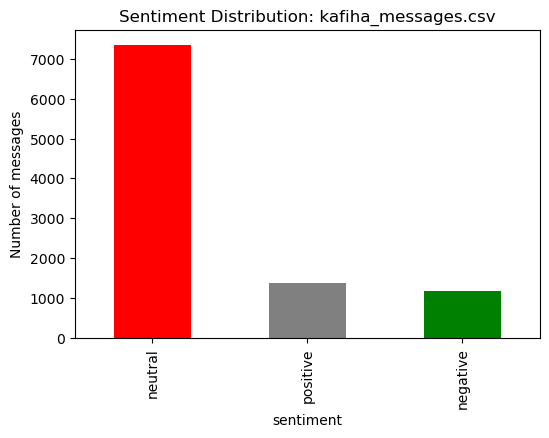

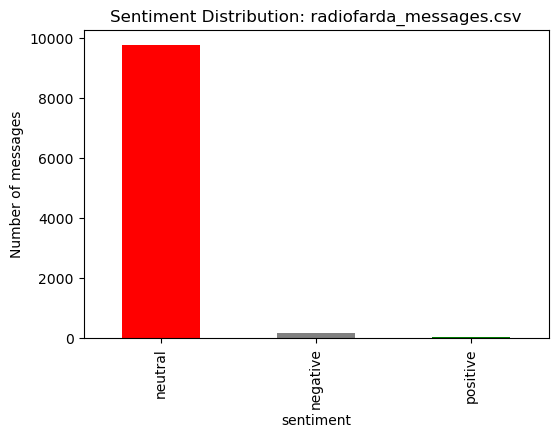

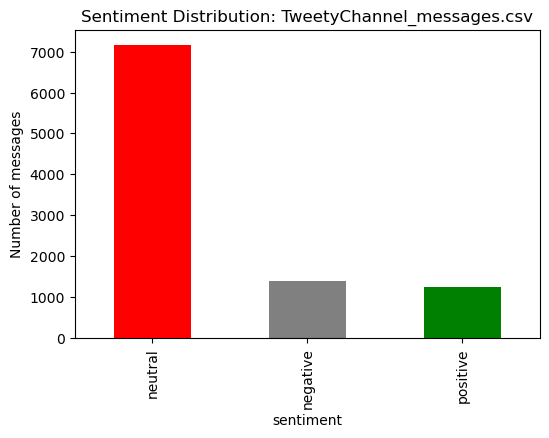

In [7]:
# Plot the sentiment distribution for each processed CSV file
for file in csv_files:
    df = pd.read_csv(os.path.join(output_path, file))
    sentiment_counts = df['sentiment'].value_counts()
    
    plt.figure(figsize=(6,4))
    sentiment_counts.plot(kind='bar', color=['red','gray','green'])
    plt.title(f"Sentiment Distribution: {file}")
    plt.ylabel("Number of messages")
    plt.show()

### ----------------------------------------
### Load all processed channel results

In [8]:
output_path = "../data/sentiment_results_batch"

channel_data = {}
for file in os.listdir(output_path):
    if file.endswith(".csv"):
        channel_name = file.replace(".csv", "")
        df = pd.read_csv(os.path.join(output_path, file))
        channel_data[channel_name] = df
        print(f"Loaded {channel_name} with {len(df)} messages")

Loaded bbcpersian_messages with 9954 messages
Loaded iranintlTV_messages with 9910 messages
Loaded kafiha_messages with 9899 messages
Loaded radiofarda_messages with 9983 messages
Loaded TweetyChannel_messages with 9814 messages


#### This cell loads the processed sentiment results for all channels into a dictionary for further analysis.

### ----------------------------------------
### Visualize Sentiment Distribution per Channel

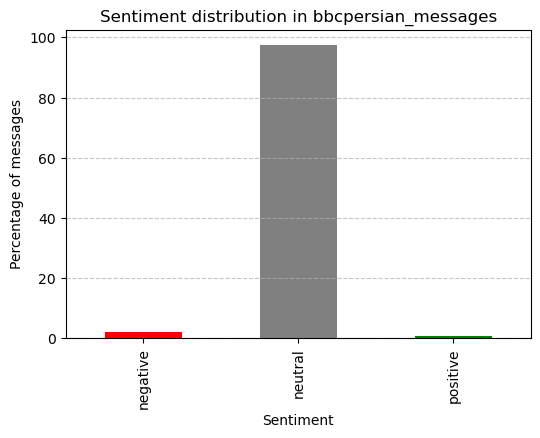

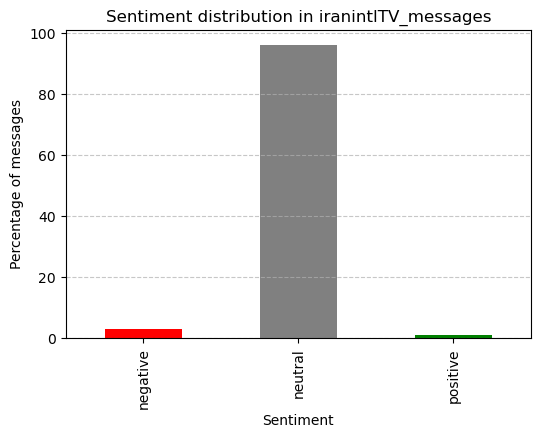

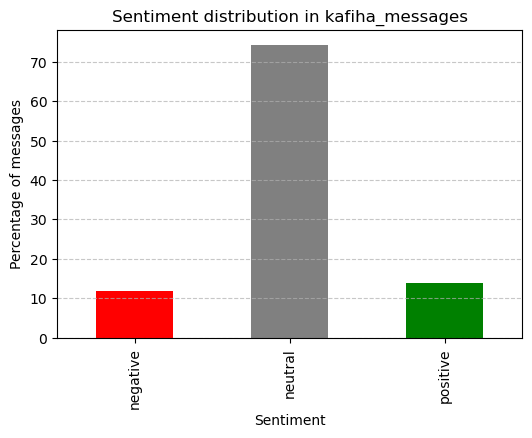

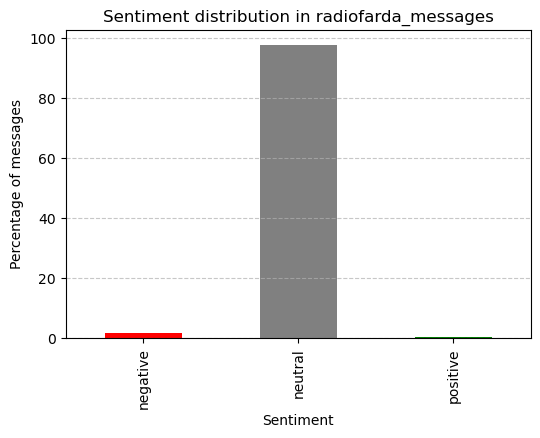

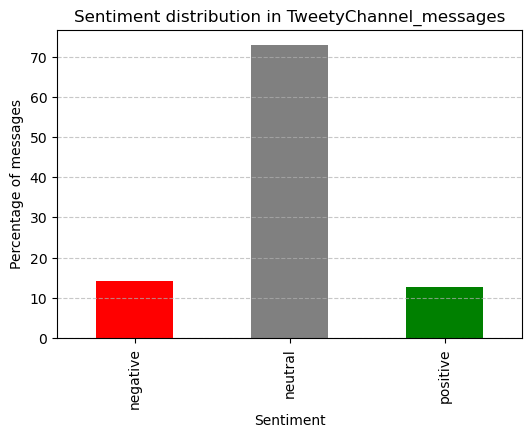

In [9]:
for name, df in channel_data.items():
    sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
    
    # Reindex to ensure correct order
    sentiment_counts = sentiment_counts.reindex(['negative', 'neutral', 'positive'])
    
    plt.figure(figsize=(6,4))
    sentiment_counts.plot(kind='bar', color=['red', 'gray', 'green'])
    plt.title(f"Sentiment distribution in {name}")
    plt.ylabel("Percentage of messages")
    plt.xlabel("Sentiment")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

#### This cell visualizes the overall sentiment balance (positive/neutral/negative) for each channel.
#### You can use this to see if the model gives reasonable distributions per channel.

### ----------------------------------------
### Manual Quality Check (Sample)

In [10]:
for name, df in channel_data.items():
    print(f"\n🔍 Channel: {name}")
    samples = df.sample(5, random_state=42)
    for _, row in samples.iterrows():
        text_preview = str(row['text'])[:80]  # convert to string first
        print(f"📝 Text: {text_preview}...")
        print(f"💬 Predicted sentiment: {row['sentiment']}")
        print("-" * 50)


🔍 Channel: bbcpersian_messages
📝 Text: 🔻گوستاوو پترو، رئیس‌جمهوری کلمبیا، در گفت‌وگو با بی‌بی‌سی هدف قرار دادن قایق‌های...
💬 Predicted sentiment: neutral
--------------------------------------------------
📝 Text: 🔻محمدباقر قالیباف، رئیس مجلس ایران در نامه‌ای به مسعود پزشکیان قانون الزام دولت ...
💬 Predicted sentiment: neutral
--------------------------------------------------
📝 Text: 🔻یک سرهنگ سابق نیروهای ویژه ایالات‌متحده که برای همکاری با «بنیاد بشردوستانه غزه...
💬 Predicted sentiment: neutral
--------------------------------------------------
📝 Text: nan...
💬 Predicted sentiment: neutral
--------------------------------------------------
📝 Text: 🔻قرار است امروز (پنجشنبه ۲۷ شهریور) اعتصاب یک روزه‌ای در سراسر فرانسه انجام شود....
💬 Predicted sentiment: neutral
--------------------------------------------------

🔍 Channel: iranintlTV_messages
📝 Text: اورشلیم‌پست در سالگرد حمله حماس نوشت جمهوری اسلامی «همچنان برای خرابکاری در طرح ...
💬 Predicted sentiment: neutral
--------------------

#### This lets you manually verify if the predicted sentiment matches the meaning of the messages.

### ----------------------------------------
### Compare Sentiment Balance Between Channels

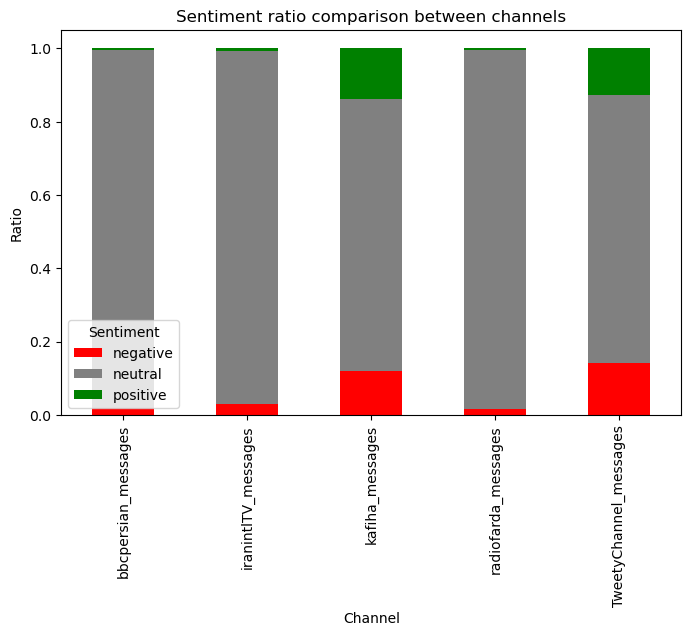

In [11]:
summary = []
for name, df in channel_data.items():
    counts = df['sentiment'].value_counts(normalize=True)
    summary.append({
        'channel': name,
        'negative': counts.get('negative', 0),
        'neutral': counts.get('neutral', 0),
        'positive': counts.get('positive', 0)
    })

# Convert to DataFrame and set index
summary_df = pd.DataFrame(summary)
summary_df.set_index('channel', inplace=True)

# Plot stacked bar chart with correct colors
summary_df.plot(kind='bar', stacked=True, figsize=(8,5),
                color=['red', 'gray', 'green'])  # negative, neutral, positive

plt.title("Sentiment ratio comparison between channels")
plt.ylabel("Ratio")
plt.xlabel("Channel")
plt.legend(title="Sentiment")
plt.show()

#### This cell shows a stacked bar chart comparing how positive/negative/neutral each channel is overall.
#### You can spot which channels are more optimistic or critical.